In [12]:
# Load in the dataset
import pandas as pd

csv_path = "training_data_2024-25.csv"
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(1752, 165)


,Unnamed: 0,GAME_DATE,WL,MIN_BIAS,MIN_MOM,MIN_AVG,MIN_MAX,FGM_BIAS,FGM_MOM,FGM_AVG,...,PF_AVG_OPP,PF_MAX_OPP,PTS_BIAS_OPP,PTS_MOM_OPP,PTS_AVG_OPP,PTS_MAX_OPP,PLUS_MINUS_BIAS_OPP,PLUS_MINUS_MOM_OPP,PLUS_MINUS_AVG_OPP,PLUS_MINUS_MAX_OPP
0,0,2024-11-12,L,242.484848,0.297203,244.909091,266.0,45.015152,-0.643357,41.090909,...,19.818182,28.0,118.030303,-0.286713,116.090909,126.0,-4.590909,-0.062937,-5.545455,15.0
1,1,2024-11-12,W,235.636364,1.017483,240.181818,241.0,37.393939,0.426573,39.909091,...,17.444444,20.0,104.533333,1.030303,109.000000,122.0,-0.866667,-0.024242,-0.888889,20.0
2,2,2024-11-12,W,239.196970,0.097902,239.727273,241.0,36.696970,0.290210,38.181818,...,22.400000,28.0,121.272727,-2.272727,109.500000,138.0,-1.290909,-0.618182,-3.000000,20.0
3,3,2024-11-12,L,242.800000,0.381818,245.444444,265.0,37.333333,-0.060606,37.666667,...,17.444444,21.0,113.000000,0.200000,114.444444,128.0,0.133333,0.721212,3.222222,30.0
4,4,2024-11-12,W,240.200000,-0.063636,239.800000,242.0,41.781818,-0.281818,40.300000,...,25.636364,34.0,123.000000,-1.576923,115.272727,133.0,-6.636364,-0.209790,-7.454545,8.0


In [13]:
# Drop unwanted columns and replace categorical data with numerical labels
# df.drop(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'MIN'], axis=1, inplace=True)
df.drop(["Unnamed: 0", "REB_BIAS", "REB_MOM", "REB_AVG", "REB_MAX", "REB_BIAS_OPP", "REB_MOM_OPP", "REB_AVG_OPP", "REB_MAX_OPP", "GAME_DATE_OPP", "WL_OPP"], axis=1, inplace=True)
df.replace({'L':0, 'W':1}, inplace=True)
df.sort_values('GAME_DATE')
df

C:\Users\gthra\AppData\Local\Temp\ipykernel_31208\65294585.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'L':0, 'W':1}, inplace=True)


,GAME_DATE,WL,MIN_BIAS,MIN_MOM,MIN_AVG,MIN_MAX,FGM_BIAS,FGM_MOM,FGM_AVG,FGM_MAX,...,PF_AVG_OPP,PF_MAX_OPP,PTS_BIAS_OPP,PTS_MOM_OPP,PTS_AVG_OPP,PTS_MAX_OPP,PLUS_MINUS_BIAS_OPP,PLUS_MINUS_MOM_OPP,PLUS_MINUS_AVG_OPP,PLUS_MINUS_MAX_OPP
0,2024-11-12,0,242.484848,0.297203,244.909091,266.0,45.015152,-0.643357,41.090909,48.0,...,19.818182,28.0,118.030303,-0.286713,116.090909,126.0,-4.590909,-0.062937,-5.545455,15.0
1,2024-11-12,1,235.636364,1.017483,240.181818,241.0,37.393939,0.426573,39.909091,46.0,...,17.444444,20.0,104.533333,1.030303,109.000000,122.0,-0.866667,-0.024242,-0.888889,20.0
2,2024-11-12,1,239.196970,0.097902,239.727273,241.0,36.696970,0.290210,38.181818,45.0,...,22.400000,28.0,121.272727,-2.272727,109.500000,138.0,-1.290909,-0.618182,-3.000000,20.0
3,2024-11-12,0,242.800000,0.381818,245.444444,265.0,37.333333,-0.060606,37.666667,42.0,...,17.444444,21.0,113.000000,0.200000,114.444444,128.0,0.133333,0.721212,3.222222,30.0
4,2024-11-12,1,240.200000,-0.063636,239.800000,242.0,41.781818,-0.281818,40.300000,46.0,...,25.636364,34.0,123.000000,-1.576923,115.272727,133.0,-6.636364,-0.209790,-7.454545,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,2025-03-29,0,240.026738,0.028724,240.515152,254.0,44.037433,-0.017265,43.818182,52.0,...,18.212121,26.0,115.625668,-0.002139,115.727273,144.0,8.518717,-0.300229,3.242424,24.0
1748,2025-03-29,0,241.342246,-0.026280,240.909091,260.0,40.695187,0.035905,41.454545,58.0,...,19.575758,28.0,108.187166,0.285103,113.000000,134.0,0.718717,0.121620,2.721212,34.0
1749,2025-03-29,1,242.689840,-0.108327,240.787879,262.0,37.016043,0.182277,40.090909,56.0,...,21.181818,34.0,107.240642,0.068602,108.121212,134.0,3.000000,-0.329412,-2.696970,23.0
1750,2025-03-29,0,241.647059,-0.036975,241.000000,256.0,36.149733,0.189763,39.454545,49.0,...,20.515152,29.0,113.770053,0.063560,114.454545,145.0,15.069519,-0.200611,11.242424,59.0


In [3]:
# Split the dataset into its inputs (X) and outputs (y) 
X = df.drop('WL', axis=1)
y = df['WL']
col_names = list(X.columns)
print(col_names)

['MIN_BIAS', 'MIN_MOM', 'MIN_AVG', 'MIN_MAX', 'FGM_BIAS', 'FGM_MOM', 'FGM_AVG', 'FGM_MAX', 'FGA_BIAS', 'FGA_MOM', 'FGA_AVG', 'FGA_MAX', 'FG_PCT_BIAS', 'FG_PCT_MOM', 'FG_PCT_AVG', 'FG_PCT_MAX', 'FG3M_BIAS', 'FG3M_MOM', 'FG3M_AVG', 'FG3M_MAX', 'FG3A_BIAS', 'FG3A_MOM', 'FG3A_AVG', 'FG3A_MAX', 'FG3_PCT_BIAS', 'FG3_PCT_MOM', 'FG3_PCT_AVG', 'FG3_PCT_MAX', 'FTM_BIAS', 'FTM_MOM', 'FTM_AVG', 'FTM_MAX', 'FTA_BIAS', 'FTA_MOM', 'FTA_AVG', 'FTA_MAX', 'FT_PCT_BIAS', 'FT_PCT_MOM', 'FT_PCT_AVG', 'FT_PCT_MAX', 'OREB_BIAS', 'OREB_MOM', 'OREB_AVG', 'OREB_MAX', 'DREB_BIAS', 'DREB_MOM', 'DREB_AVG', 'DREB_MAX', 'REB_BIAS', 'REB_MOM', 'REB_AVG', 'REB_MAX', 'AST_BIAS', 'AST_MOM', 'AST_AVG', 'AST_MAX', 'STL_BIAS', 'STL_MOM', 'STL_AVG', 'STL_MAX', 'BLK_BIAS', 'BLK_MOM', 'BLK_AVG', 'BLK_MAX', 'TOV_BIAS', 'TOV_MOM', 'TOV_AVG', 'TOV_MAX', 'PF_BIAS', 'PF_MOM', 'PF_AVG', 'PF_MAX', 'PTS_BIAS', 'PTS_MOM', 'PTS_AVG', 'PTS_MAX', 'PLUS_MINUS_BIAS', 'PLUS_MINUS_MOM', 'PLUS_MINUS_AVG', 'PLUS_MINUS_MAX', 'WL_OPP', 'MIN_BIAS

In [4]:
# Split data into train, val, and test subdatasets and scale features 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

seed = 42
test_size_ratio = .15
eval_size_ratio = .15 / (1-test_size_ratio)

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=test_size_ratio, random_state=seed)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=eval_size_ratio, random_state=seed)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
X_eval = pd.DataFrame(scaler.transform(X_eval), columns=X.columns, index=X_eval.index)
y_train = pd.DataFrame(y_train, index=y_train.index)
y_test = pd.DataFrame(y_test, index=y_test.index)
y_eval = pd.DataFrame(y_eval, index=y_eval.index)

In [5]:
# Impute any NAs with the mean of the feature which is 0 based on the standard scaling that was done previously
import numpy as np
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
X_eval.fillna(0, inplace=True)

In [1]:
# Defined functions that create and display a heatmap and correlation matrix as well as a function that drops redundant features from a dataset
import seaborn as sns
import matplotlib.pyplot as plt

def display_heatmap(matrix, title, xlabel, ylabel, plot_corr, save_corr, cmap='bwr'):
    plt.figure(figsize=(60, 48))
    sns.heatmap(matrix, annot=True, cmap=cmap, fmt=".2f")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_corr:
        plt.savefig(f"ml_imgs/{title}.png")
    if plot_corr:
        plt.show()
    plt.close()

def correlation_matrix(dataframe, threshold_mag=None, lower=False, k=0, plot_corr=False, xlabel=None, ylabel=None, title_append=None, save_corr=False):
    title = "Feature Correlation Matrix"
    corr_matrix = dataframe.copy().corr()
    
    if threshold_mag:
        corr_matrix *= (abs(corr_matrix) >= threshold_mag)
        corr_matrix = corr_matrix.map(lambda x: 0 if abs(x) < 1e-10 else x)
        title += f" (Threshold Magnitude of {threshold_mag})"
        
    if lower:
        corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=k).astype(bool))
        title = "Lower Triangular " + title
    
    if title_append:
        title += title_append
    if plot_corr or save_corr:
        display_heatmap(corr_matrix, title, xlabel, ylabel, plot_corr, save_corr)

    return corr_matrix
        
def get_dropped_features(dataframe, threshold_mag=0.7):
    corr_matrix = correlation_matrix(dataframe=dataframe, threshold_mag=threshold_mag, lower=False, plot_corr=False)
    
    edge_conns = {}
    col_names_df = list(corr_matrix.columns)
    corr_matrix = corr_matrix.values.tolist()
    
    for i in range(len(corr_matrix)):
        num_edge = 0
        nodes_connected_to = set()
        for j in range(len(corr_matrix[i])):
            if j == i:
                continue
            val = corr_matrix[i][j]
            if abs(float(val)) >= 0.7:
                num_edge += 1
                nodes_connected_to.add(col_names_df[j])
        
        if num_edge != 0:
            edge_conns[col_names_df[i]] = [num_edge, nodes_connected_to]
    
    dropped_features = set()
    while edge_conns:
        edge_conns = dict(sorted(edge_conns.items(), key=lambda item: item[1][0], reverse=True))
        safe_node = list(edge_conns.keys())[0]
        neighbors = edge_conns[safe_node][1] or []
        newly_dropped_nodes = list(neighbors)
        dropped_features.update(newly_dropped_nodes)
        del edge_conns[safe_node]
        
        for dropped_node in newly_dropped_nodes:
            new_num_conn_nodes = edge_conns[dropped_node][0] - 1
            if new_num_conn_nodes == 0:
                del edge_conns[dropped_node]
            else:
                edge_conns[dropped_node][0] = new_num_conn_nodes
                edge_conns[dropped_node][1].discard(safe_node)
    
    return dropped_features

In [7]:
# Create and display correlation matrix; drop as many redundant features as possible while preserving as much info as possible
threshold_mag = 0.7
# correlation_matrix(X_train, threshold_mag=None, lower=False, plot_corr=True, xlabel="Features", ylabel="Features")
dropped_features = get_dropped_features(X_train, threshold_mag=threshold_mag)
print(f"Dropped features ({len(dropped_features)} total) with threshold magnitude of {threshold_mag}: {dropped_features}")
X_train.drop(dropped_features, axis=1, inplace=True)
X_test.drop(dropped_features, axis=1, inplace=True)
X_eval.drop(dropped_features, axis=1, inplace=True)
col_names = [feature for feature in col_names if feature not in dropped_features]
print(f"Remaining features ({len(col_names)} total): {col_names}")
# correlation_matrix(X_train, threshold_mag=None, lower=False, plot_corr=True, xlabel="Features", ylabel="Features")

Dropped features (93 total) with threshold magnitude of 0.7: {'REB_BIAS', 'FG_PCT_MAX_OPP', 'FG3M_MOM', 'FT_PCT_MOM_OPP', 'FG_PCT_MAX', 'FG3A_BIAS', 'REB_MOM_OPP', 'BLK_AVG_OPP', 'FTA_AVG', 'DREB_BIAS', 'FTA_MOM', 'FGA_MOM_OPP', 'FG3M_MAX_OPP', 'OREB_AVG', 'FG3A_MAX', 'FG3M_MAX', 'REB_BIAS_OPP', 'PF_MOM', 'REB_MAX_OPP', 'FTM_MAX_OPP', 'FTM_BIAS_OPP', 'FG3A_BIAS_OPP', 'FG_PCT_BIAS', 'OREB_MOM_OPP', 'FG3A_MAX_OPP', 'FG3M_AVG', 'FTA_BIAS', 'FTM_MAX', 'DREB_MOM_OPP', 'TOV_AVG', 'FT_PCT_MOM', 'MIN_MOM', 'TOV_AVG_OPP', 'MIN_BIAS_OPP', 'FG3A_MOM', 'FG3_PCT_MOM_OPP', 'FTM_BIAS', 'MIN_BIAS', 'FG_PCT_MOM_OPP', 'FT_PCT_BIAS', 'REB_AVG', 'FG_PCT_BIAS_OPP', 'FT_PCT_BIAS_OPP', 'MIN_MOM_OPP', 'FTA_MOM_OPP', 'FGM_BIAS', 'PTS_MOM', 'FTA_BIAS_OPP', 'PF_AVG_OPP', 'FTA_MAX', 'FGM_BIAS_OPP', 'FTM_MOM', 'FGA_BIAS', 'STL_AVG', 'FG3_PCT_MOM', 'DREB_MOM', 'OREB_MOM', 'FG3_PCT_BIAS', 'PTS_BIAS', 'FTA_AVG_OPP', 'FGA_BIAS_OPP', 'FGA_MOM', 'PF_AVG', 'FG3M_AVG_OPP', 'AST_MAX_OPP', 'PLUS_MINUS_AVG', 'FGM_MOM_OPP', '

In [8]:
# Fit a PCA to determine how to reduce the number dimensions in the dataset feature space while preserving a certain threshold of explained variance
from sklearn.decomposition import PCA

X_train_idxs = X_train.index
X_test_idxs = X_test.index
X_eval_idxs = X_eval.index

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_eval = pca.transform(X_eval)

n_components = X_train.shape[1]
pc_columns = [f'PC{i+1}' for i in range(n_components)]
X_train = pd.DataFrame(X_train, columns=pc_columns, index=X_train_idxs)
X_test = pd.DataFrame(X_test, columns=pc_columns, index=X_test_idxs)
X_eval = pd.DataFrame(X_eval, columns=pc_columns, index=X_eval_idxs)

In [9]:
# Defined function to display bar graphs
def display_bar_graph(x_vals, y_vals, title, xlabel, ylabel):
    plt.figure(figsize=(60, 48))
    plt.bar(x_vals, y_vals)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(title)
    plt.show()

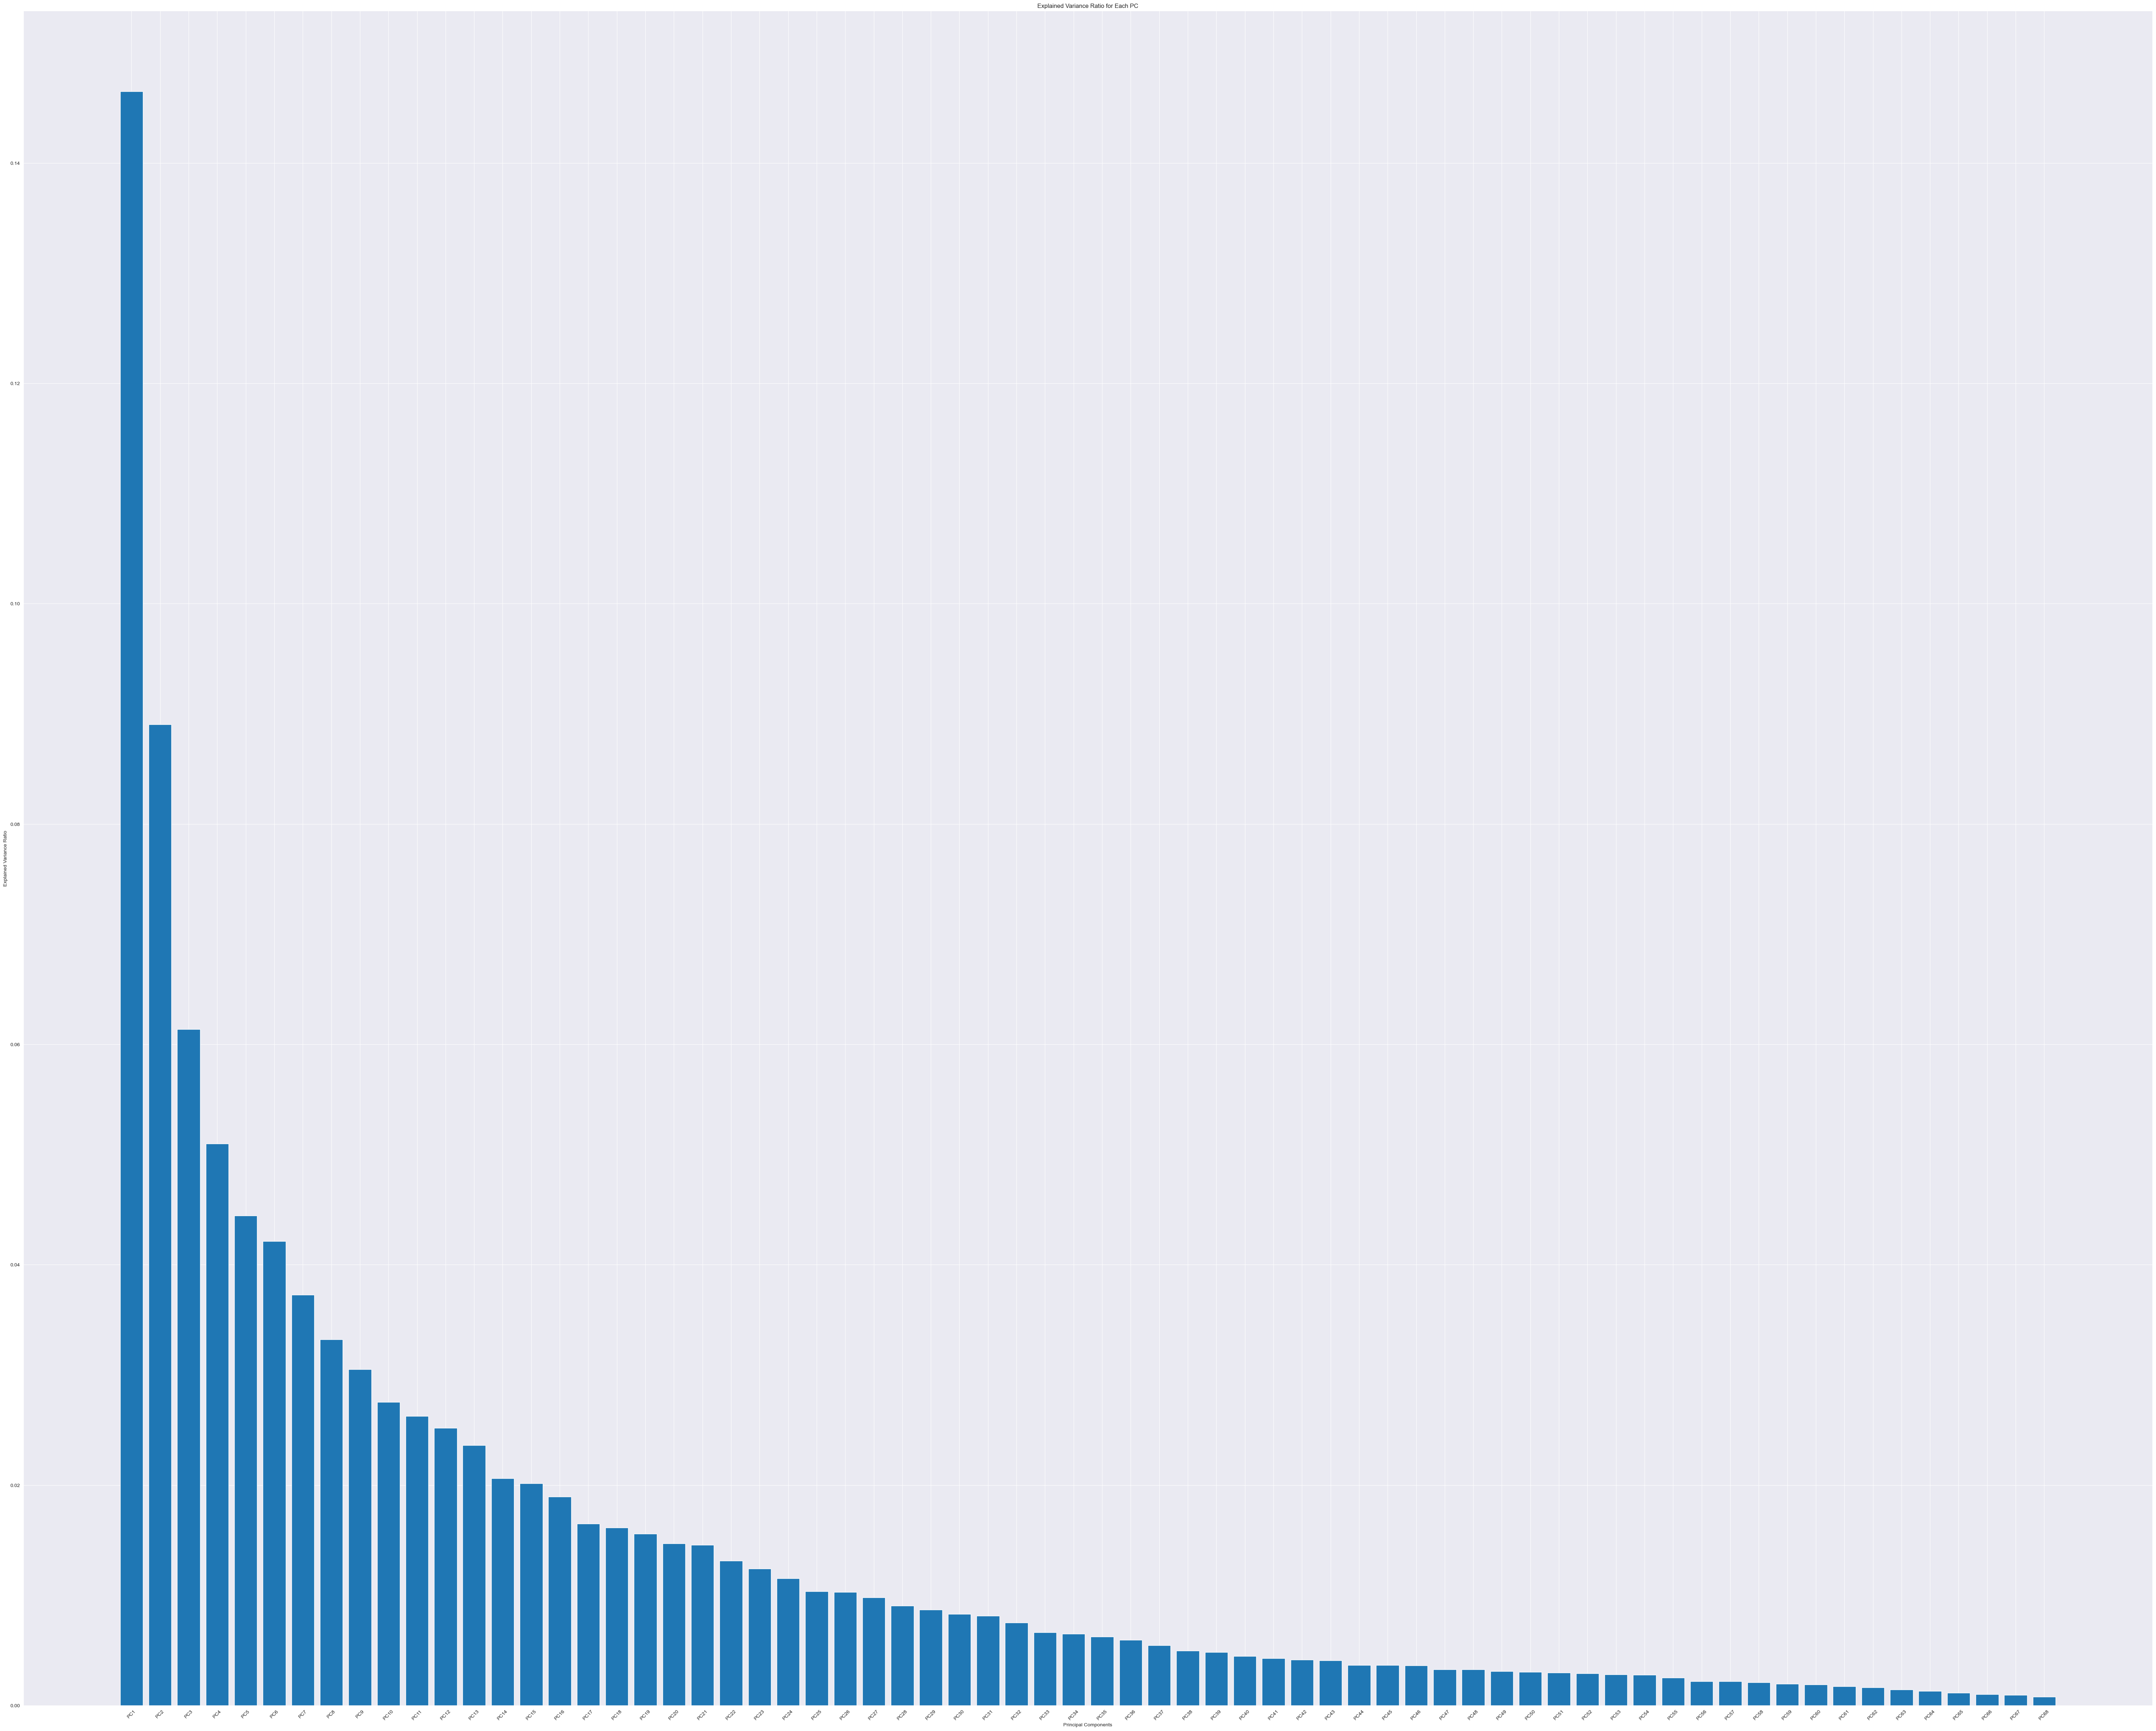

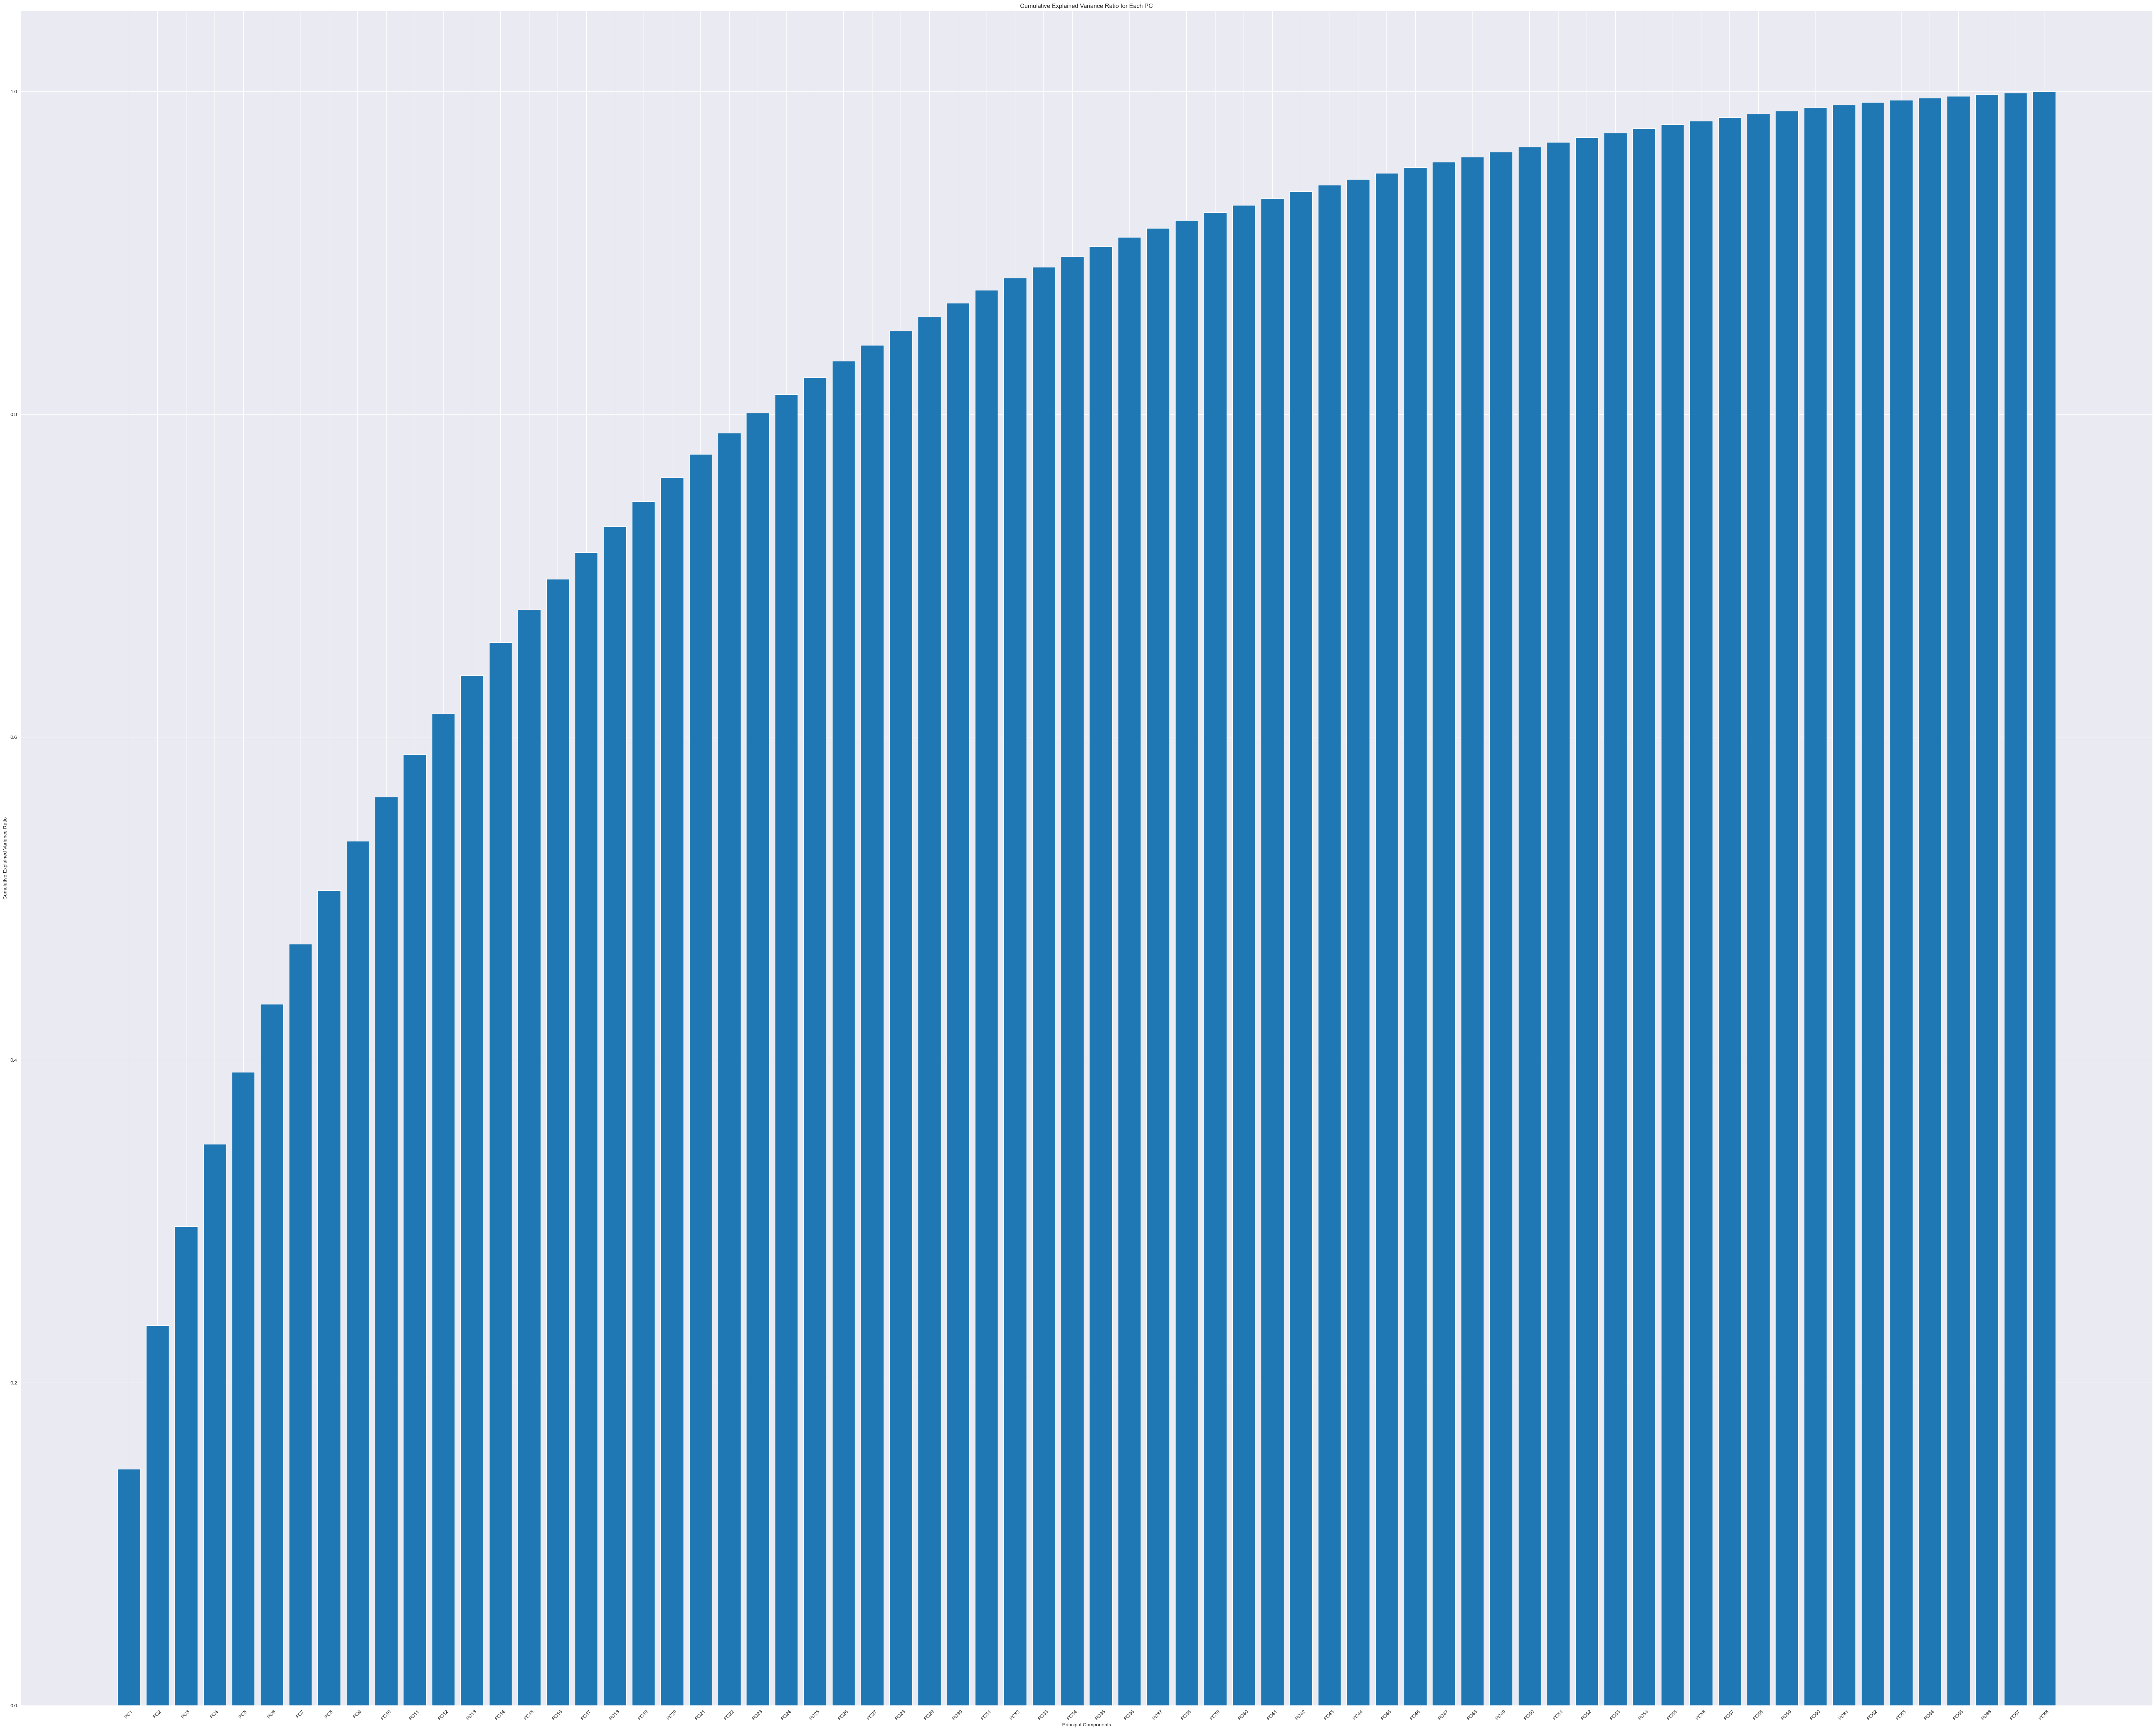

In [10]:
# Displaying the explained variance ratio and cumulative explained variance ratio for each PC
display_bar_graph(pc_columns, pca.explained_variance_ratio_, "Explained Variance Ratio for Each PC", "Principal Components", "Explained Variance Ratio")
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
display_bar_graph(pc_columns, cumulative_variance, "Cumulative Explained Variance Ratio for Each PC", "Principal Components", "Cumulative Explained Variance Ratio")

In [11]:
# Get the PCs to keep that explain a minimum of a certain threshold of variance
def calc_last_pc_idx_to_keep(cumulative_variance, threshold_var_explained):
    over_threshold_var_explained = cumulative_variance - threshold_var_explained
    for i in range(len(over_threshold_var_explained)):
        if over_threshold_var_explained[i] >= 0:
            return i
        
    return len(over_threshold_var_explained) - 1

threshold_var_explained = 0.9
last_pc_idx = calc_last_pc_idx_to_keep(cumulative_variance, threshold_var_explained)
print(f"Keeping the first {last_pc_idx+1} PCs as they explain at or above the variance threshold of {100 * threshold_var_explained}% at {round(100 * cumulative_variance[last_pc_idx], 2)}%")

X_train = X_train.iloc[:, :last_pc_idx+1]
X_test = X_test.iloc[:, :last_pc_idx+1]
X_eval = X_eval.iloc[:, :last_pc_idx+1]
print("The shapes of X_train, X_test, and X_eval are, respectively:", X_train.shape, X_test.shape, X_eval.shape)

pc_columns = pc_columns[:last_pc_idx+1]
print(f"Remaining columns ({len(pc_columns)} total): {pc_columns}")

Keeping the first 35 PCs as they explain at or above the variance threshold of 90.0% at 90.39%
The shapes of X_train, X_test, and X_eval are, respectively: (1226, 35) (263, 35) (263, 35)
Remaining columns (35 total): ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35']


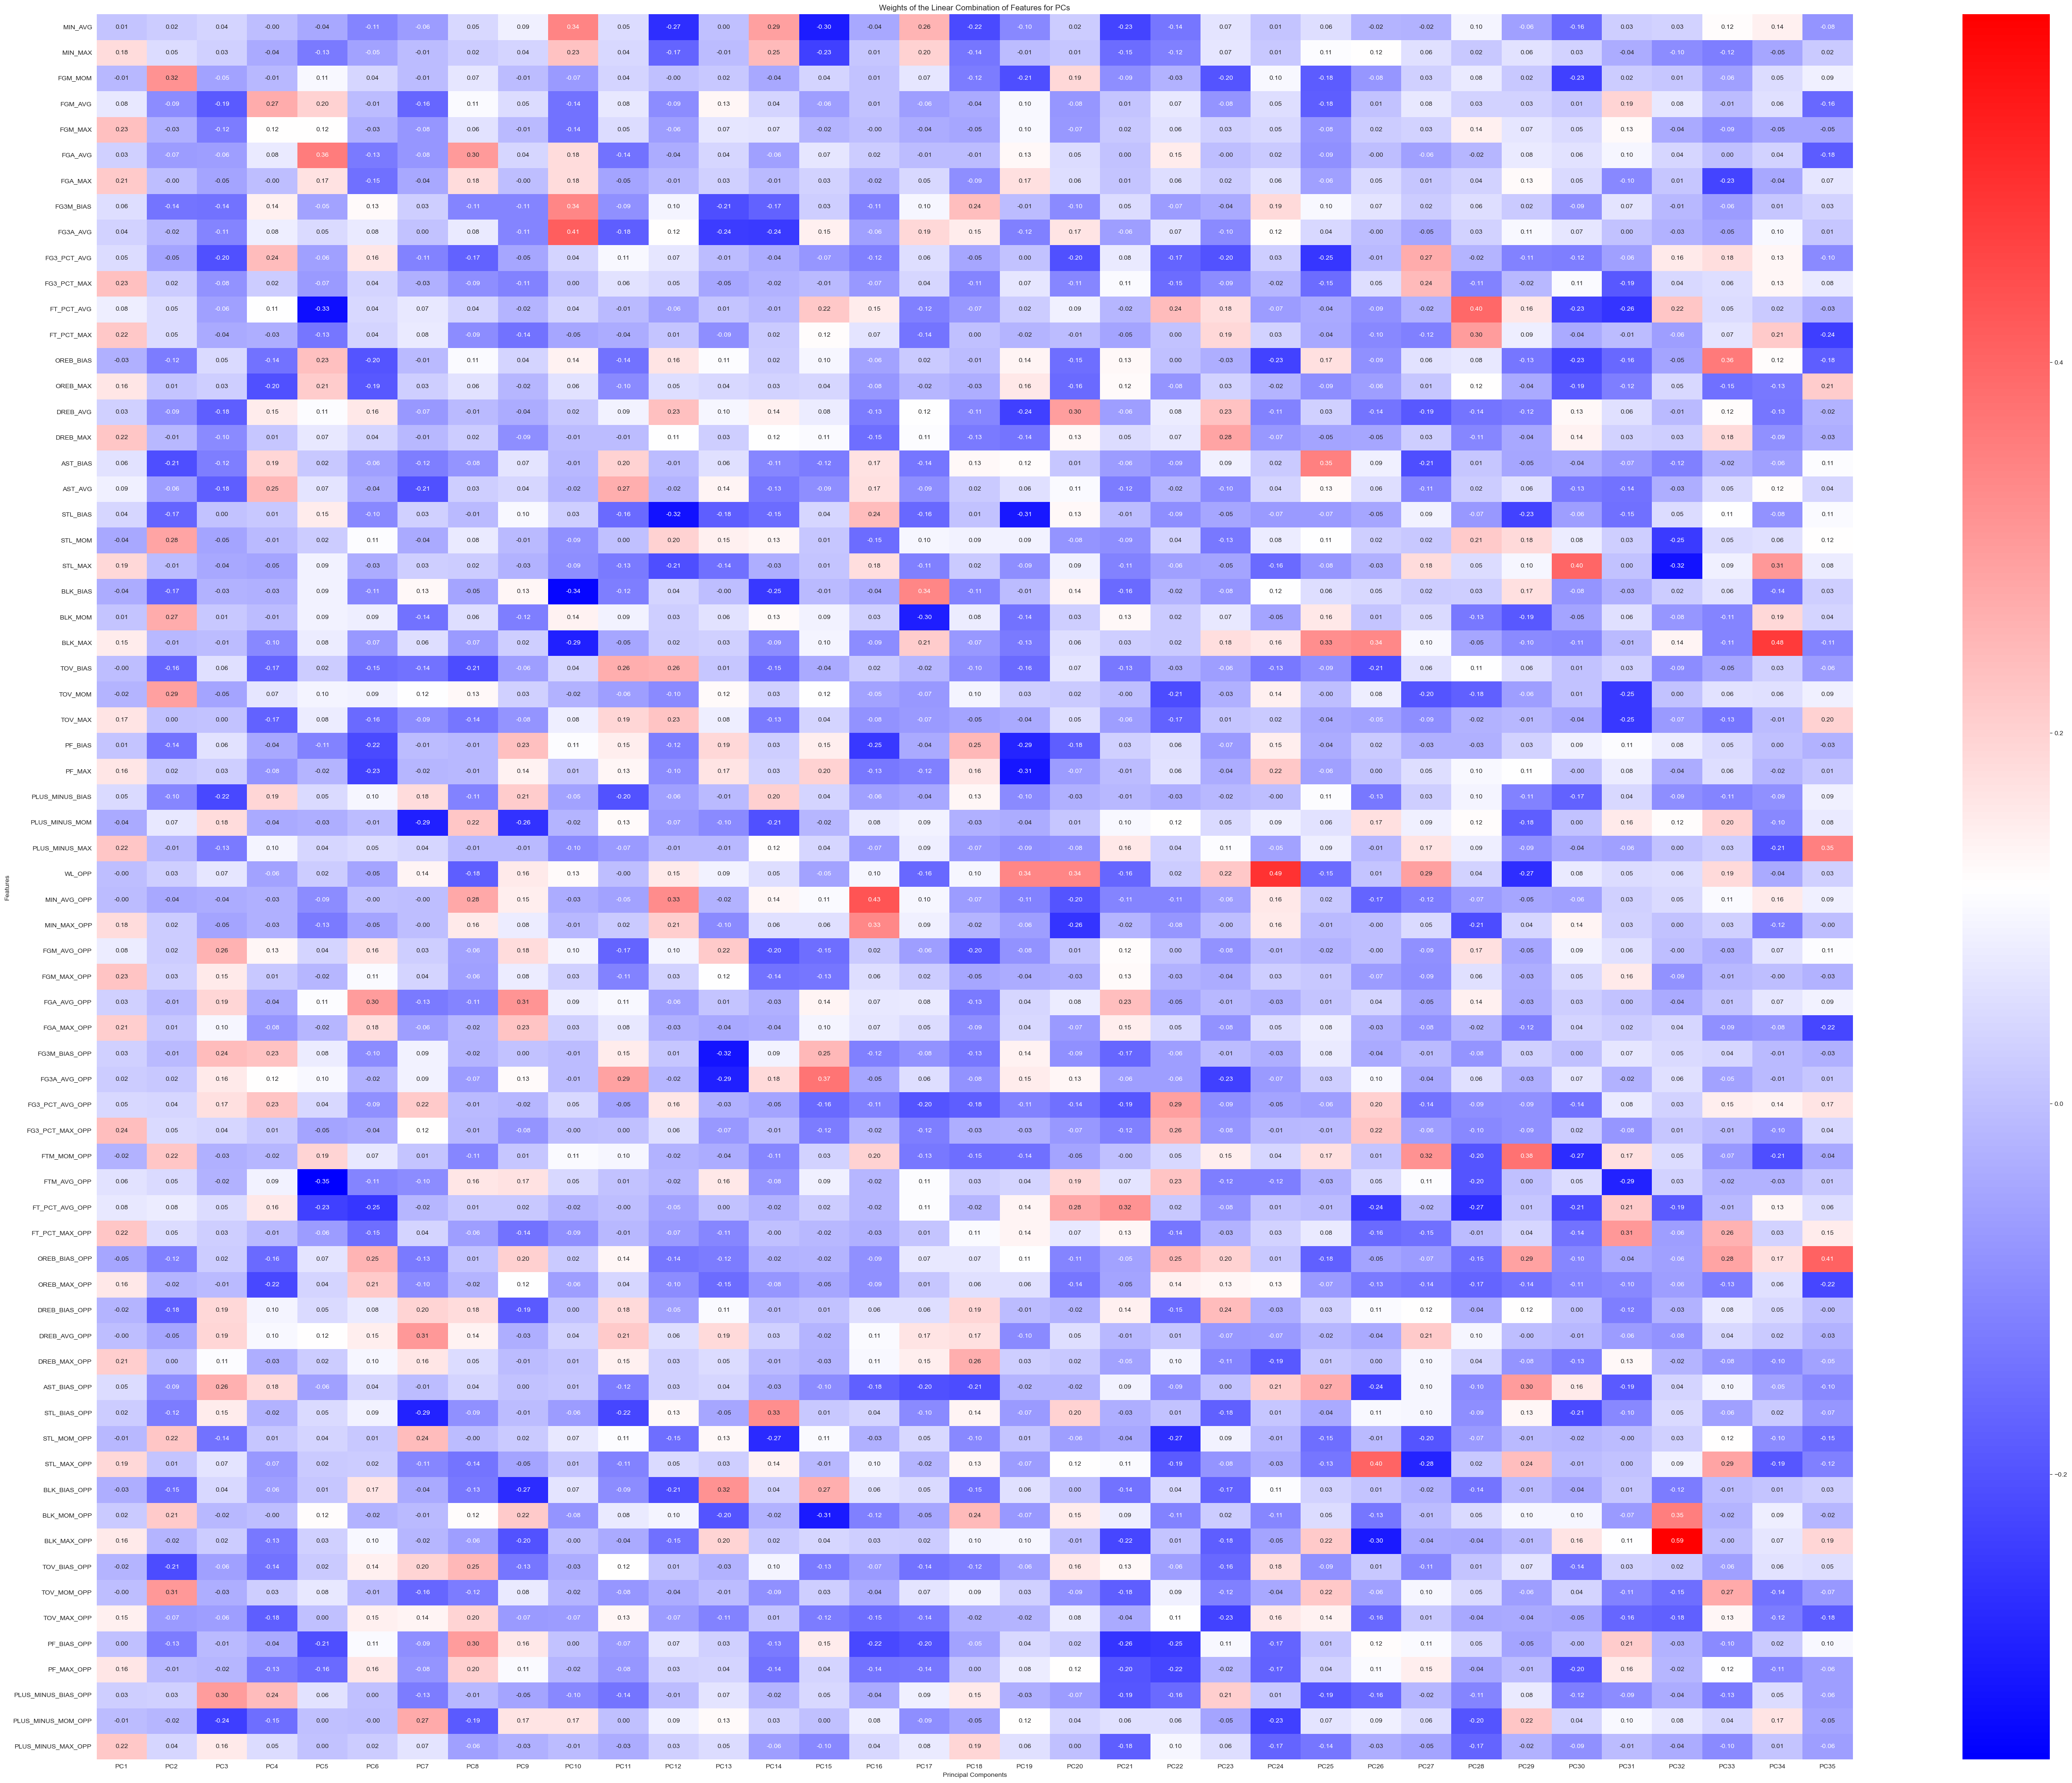

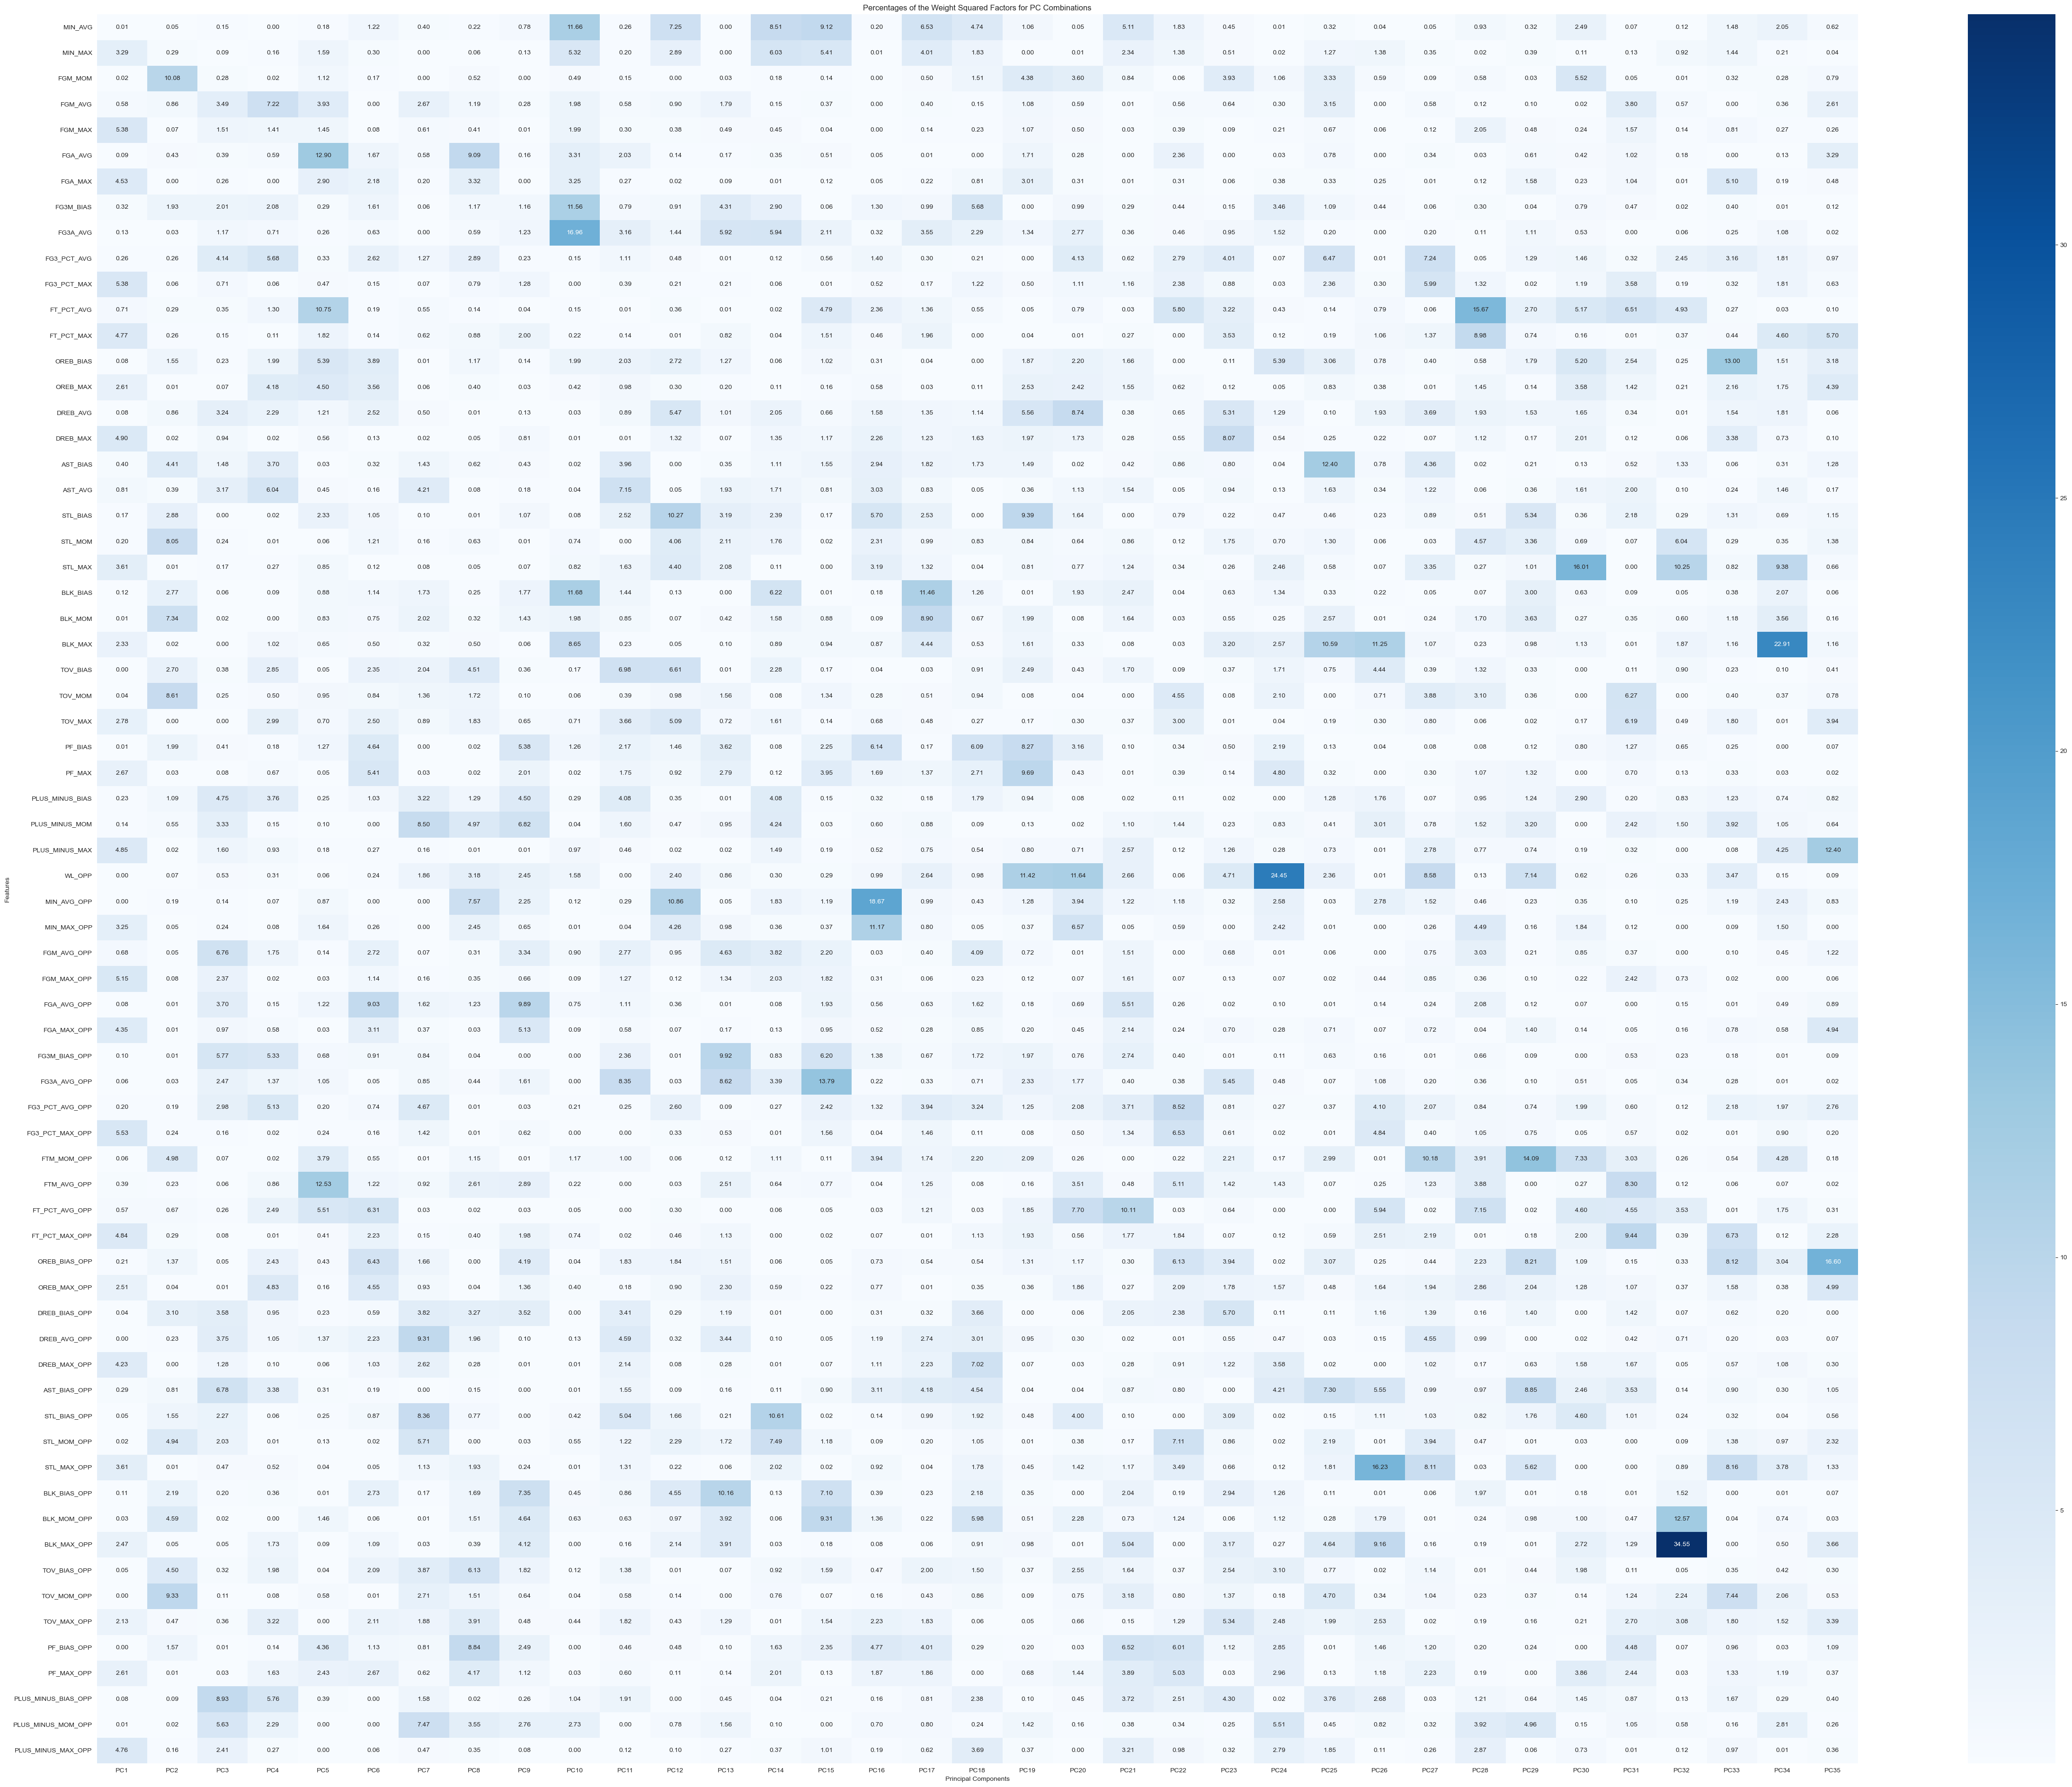

,Global Feature Percentage
WL_OPP,1.622435
BLK_MAX_OPP,1.566580
OREB_BIAS_OPP,1.566100
BLK_MAX,1.542208
FTM_MOM_OPP,1.541041
...,...
FGM_MAX_OPP,1.359416
PLUS_MINUS_MAX,1.358656
DREB_MAX_OPP,1.355990
FG3_PCT_MAX_OPP,1.344326


In [12]:
# Display heatmaps and a chart to interpret the results of the PCA transformation done on the dataset
loadings = pd.DataFrame(
    pca.components_.T[:, :last_pc_idx+1],
    index=col_names,
    columns=pc_columns
)

display_heatmap(loadings, "Weights of the Linear Combination of Features for PCs", "Principal Components", "Features")

contributions_percentages = []
for pc in loadings.columns:
    pc_vector = loadings[pc]
    contributions_percentages.append(list(100 * (pc_vector**2) / np.sum(pc_vector**2)))

contributions_percentages = pd.DataFrame(
    np.array(contributions_percentages).T,
    index=col_names,
    columns=pc_columns
)
display_heatmap(contributions_percentages, "Percentages of the Weight Squared Factors for PC Combinations", "Principal Components", "Features", cmap="Blues")

weighted_contributions = (loadings ** 2) * pca.explained_variance_ratio_[:last_pc_idx+1]
global_feature_contributions = weighted_contributions.sum(axis=1)
global_feature_percent = (global_feature_contributions / global_feature_contributions.sum()) * 100
global_feature_percent = pd.DataFrame(
    global_feature_percent.sort_values(ascending=False),
    columns=["Global Feature Percentage"]
)

global_feature_percent

In [13]:
# Save the following feature engineered datasets to avoid having to rerun the script everytime: X_train, X_test, X_eval, y_train, y_test, and y_eval
import os
import shutil

saved_feature_engineered_data_dir_path = 'feature_engineered_data/'
if os.path.exists(saved_feature_engineered_data_dir_path):
    shutil.rmtree(saved_feature_engineered_data_dir_path)
os.makedirs(saved_feature_engineered_data_dir_path)

X_train.to_parquet(saved_feature_engineered_data_dir_path + "X_train.parquet")
X_test.to_parquet(saved_feature_engineered_data_dir_path + "X_test.parquet")
X_eval.to_parquet(saved_feature_engineered_data_dir_path + "X_eval.parquet")
y_train.to_parquet(saved_feature_engineered_data_dir_path + "y_train.parquet")
y_test.to_parquet(saved_feature_engineered_data_dir_path + "y_test.parquet")
y_eval.to_parquet(saved_feature_engineered_data_dir_path + "y_eval.parquet")